## Exploratory Data Analysis
### Instacart Market Basket Analysis

This notebook performs explortory data analysis on the Instacart Online Grocery Shopping dataset. 
The goal of the EDA are to:
- Unserstand the structure and statistics of the data.
- Visualize user behavior, product demand, and reorder patterns.
- Identify relationships and insights that will guide preprocessing and feature engineering.

### Loading the necessary libraries and data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

RAW = Path("../data/raw")
PROCESSED = Path("../data/processed")

orders = pd.read_csv(RAW/"orders.csv")
order_prod_prior = pd.read_csv(RAW/"order_products__prior.csv")
order_prod_train = pd.read_csv(RAW/"order_products__train.csv")
products = pd.read_csv(RAW/"products.csv")
aisles = pd.read_csv(RAW/"aisles.csv")
departments = pd.read_csv(RAW/"departments.csv")

print("Orders:", orders.shape)
print("Order Products Prior:", order_prod_prior.shape)
print("Order Products Train:", order_prod_train.shape)
print("Products:", products.shape)
print("Aisles:", aisles.shape)
print("Departments:", departments.shape)

orders['user_id'].nunique()


Orders: (3421083, 7)
Order Products Prior: (32434489, 4)
Order Products Train: (1384617, 4)
Products: (49688, 4)
Aisles: (134, 2)
Departments: (21, 2)


206209

### Dataset Overview

- **orders.csv**: Contains order-level information such as order number, day of week, hour of day, and days since prior order.  
- **order_products__prior.csv**: Line-item details of products from prior orders (used for feature engineering and EDA).  
- **order_products__train.csv**: Line-item details of products from training orders (used for supervised learning).  
- **products.csv**: Product metadata including product name, aisle, and department IDs.  
- **aisles.csv**: Aisle names and IDs.  
- **departments.csv**: Department names and IDs.  

For EDA, we primarily use `orders` (eval_set = "prior") joined with `order_products__prior` and product metadata.


### Data Overview and Statistics

Before visualizing, we examine the structure and summary statistics of the datasets.  
This helps identify missing values, variable types, and potential issues (e.g., outliers, skewness).


In [2]:
# Orders dataset
display(orders.head())
orders.info()
orders[['order_hour_of_day', 'order_dow', 'days_since_prior_order']].describe().T
print("orders eval_set distribution:", orders["eval_set"].value_counts(normalize=True))


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
orders eval_set distribution: eval_set
prior    0.939724
train    0.038353
test     0.021923
Name: proportion, dtype: float64


- `order_id` and `user_id` are identifiers.  
- `eval_set` has values: prior, train, test (only prior used for EDA).  
- `order_number` shows sequence per user. (1 being the first order, 2 being second order and so on)  
- `order_dow` (0–6) - Sunday through Saturday
- `order_hour_of_day` (0–23) represent timing.  
- `days_since_prior_order` The number of days between current order and the user's previous order and has missing values for first orders.  

In [3]:
# Prior order products
display(order_prod_prior.head())
order_prod_prior.info()
order_prod_prior[['add_to_cart_order','reordered']].describe().T


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


,count,mean,std,min,25%,50%,75%,max
add_to_cart_order,32434489.0,8.351076,7.126671,1.0,3.0,6.0,11.0,145.0
reordered,32434489.0,0.589697,0.491889,0.0,0.0,1.0,1.0,1.0


- Contains product-level details for prior orders.  
- `add_to_cart_order` shows position of the product in the user's cart.  
- `reordered`: binary (1 if the product was ordered before by the same user, else 0).  
- This is the core table for analyzing product-level reorder behavior.  

In [4]:
# Products metadata
display(products.head())
print("Unique products:", products['product_id'].nunique())
print("Unique aisles:", aisles['aisle_id'].nunique())
print("Unique departments:", departments['department_id'].nunique())


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Unique products: 49688
Unique aisles: 134
Unique departments: 21


- `products.csv` links products to aisles and departments.  
- There are 49,688 unique products, spread across 134 aisles and 21 departments.  
- This metadata will be useful for grouping and visualization.  

### Missing Values Check

In [5]:
# Missing values across datasets
missing_orders = orders.isnull().sum()
missing_prior = order_prod_prior.isnull().sum()
missing_products = products.isnull().sum()

print("Missing values in orders:")
print(missing_orders[missing_orders > 0])

print("\nMissing values in order_products__prior:")
if (missing_prior[missing_prior > 0]).any():
    print(missing_prior[missing_prior > 0])
else:
    print("No missing values")

print("\nMissing values in products:")
if (missing_products[missing_products > 0]).any():
    print(missing_products[missing_products > 0])
else:
    print("No missing values")


Missing values in orders:
days_since_prior_order    206209
dtype: int64

Missing values in order_products__prior:
No missing values

Missing values in products:
No missing values


### Data Visualization
This section visualizes user behavior, product demand, and reorder patterns using the PRIOR orders.

Defining the path where the graphs and figures will be stored. 

In [6]:
FIG_DIR = Path("reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Using PRIOR orders for EDA
orders_prior = orders.loc[orders["eval_set"] == 'prior'].copy()

print("orders_prior shape:", orders_prior.shape)
print("order eval_set value counts:\n", orders["eval_set"].value_counts())


orders_prior shape: (3214874, 7)
order eval_set value counts:
 eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


### User Behavior
#### Orders by Day of Week
This plot shows how Instacart orders are distributed across the days of the week. 
The 'order_dow' variable range from 0-6, where 0 corresponds to Sunday and 6 to Saturday.

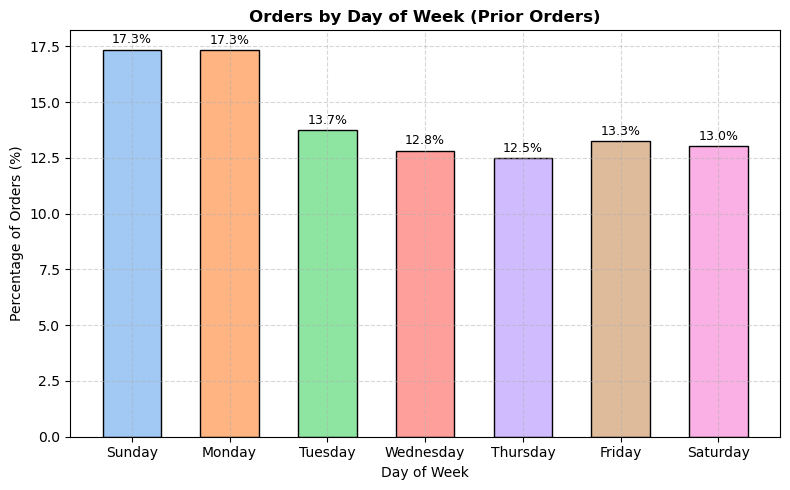

In [7]:
dow_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 
           4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

dow_counts = (orders_prior['order_dow'].value_counts().sort_index()
              .rename_axis('order_dow').reset_index(name='orders'))

dow_counts['day'] = dow_counts['order_dow'].map(dow_map)
dow_counts['percentage'] = 100 * dow_counts['orders'] / dow_counts['orders'].sum()

# Plotting
plt.figure(figsize=(8,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
bars = plt.bar(dow_counts['day'], dow_counts['percentage'],
               color = sns.color_palette("pastel"),
               edgecolor='black',
               width = 0.6)

# Annotate bars with percentages
for bar, pct in zip(bars, dow_counts['percentage']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15, 
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.title('Orders by Day of Week (Prior Orders)', fontsize = 12, weight='bold')
plt.xlabel('Day of Week', fontsize = 10)
plt.ylabel('Percentage of Orders (%)', fontsize = 10)
plt.tight_layout()

fig_path = FIG_DIR / "EDA-01_orders_by_dow.png"
plt.savefig(fig_path, dpi=150)
plt.show()

**Interpretation.**  
Orders vary noticeably by day of week where most orders occur on Sundays and Mondays,indicating that customers tend to restock groceries at the start of the week.  
Order volume slows down from Tuesday through Saturday, suggesting less activity after initial grocery purchase.  

This pattern implies that **day-of-week** can serve as an important feature in predictive models—capturing routine behavior and planning cycles in customer purchasing habits.

#### Orders by Hour of Day

This plot displays how Instacart orders are distributed by the hour of the day (0–23).  
Understanding hourly shopping trends helps identify peak activity periods and user engagement patterns.


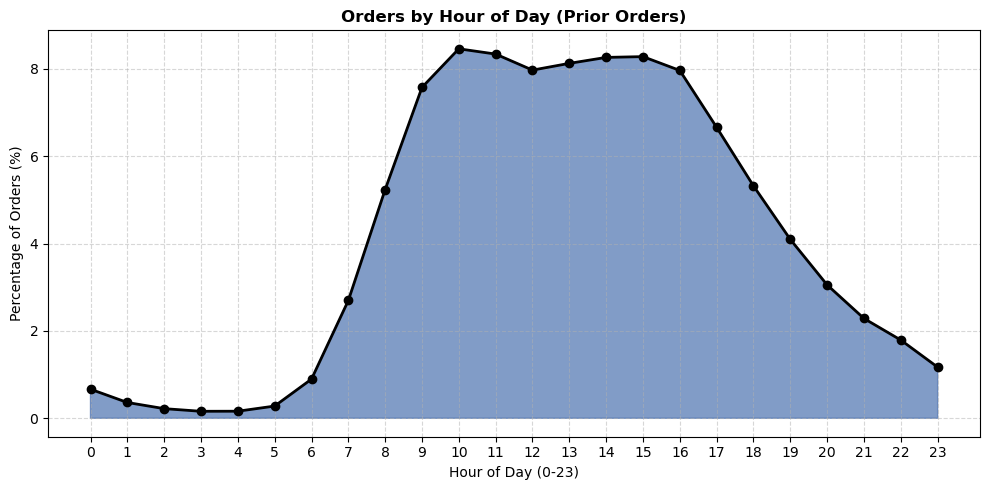

In [8]:
# Aggerate total orders by hour of day
hour_counts = (orders_prior['order_hour_of_day'].value_counts().sort_index()
               .rename_axis('order_hour_of_day').reset_index(name='orders'))

hour_counts['percentage'] = 100 * hour_counts['orders'] / hour_counts['orders'].sum()

# Plotting
plt.figure(figsize=(10,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.plot(hour_counts['order_hour_of_day'], hour_counts['percentage'],
         marker='o', color = "black", markersize=6, linewidth=2)
plt.fill_between(hour_counts['order_hour_of_day'], hour_counts['percentage'],
                 color = sns.color_palette("deep"), alpha=0.7)

plt.title('Orders by Hour of Day (Prior Orders)', fontsize = 12, weight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize = 10)
plt.ylabel('Percentage of Orders (%)', fontsize = 10)
plt.xticks(range(0,24))
plt.tight_layout()

fig_path = FIG_DIR / "EDA-02_orders_by_hour.png"
plt.savefig(fig_path, dpi=150)
plt.show()




**Interpretation.**  
Order volume is lowest during late-night hours and rises sharply in the **morning**, peaking between **10 AM and 4 PM**.  After 5 PM, activity declines steadily until 6 AM next day.  

This suggests that most users place grocery orders **during midday or early afternoon**, possibly during breaks or after work.  
The clear daily rhythm supports using **hour-of-day** as a time-based feature in predictive or recommendation models.

#### Days Since Prior Order Distribution

This plot illustrates the distribution of `days_since_prior_order`, which measures the number of days between a user's current and previous orders. It helps reveal customers' ordering frequency patterns.

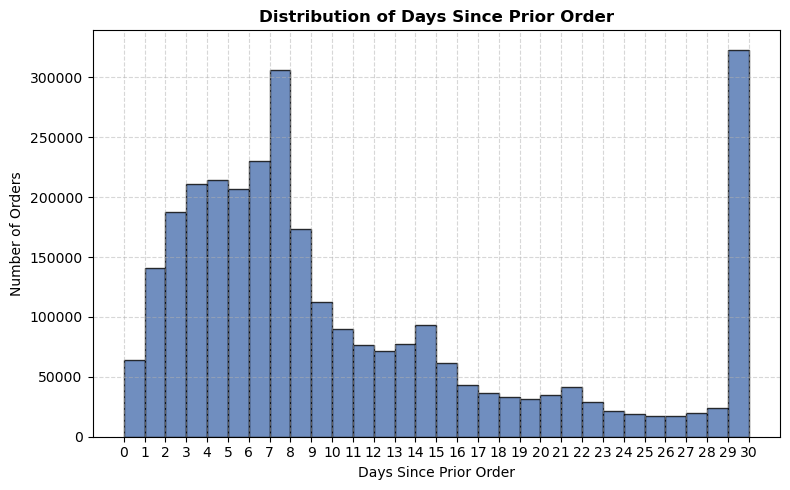

In [9]:
# Excluding the first order (NaN days_since_prior_order)
valid_orders = orders_prior.dropna(subset=['days_since_prior_order'])

plt.figure(figsize = (8,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.hist(valid_orders['days_since_prior_order'], 
         bins = 30, color = sns.color_palette("deep")[0], 
         edgecolor='black', alpha=0.8)
plt.title('Distribution of Days Since Prior Order', fontsize = 12, weight='bold')
plt.xlabel('Days Since Prior Order', fontsize = 10)
plt.ylabel('Number of Orders', fontsize = 10)
plt.xticks(range(0,31))
plt.tight_layout()

# Save figure
fig_path = FIG_DIR / "EDA-03_days_since_prior_order.png"
plt.savefig(fig_path, dpi=150)  
plt.show()


**Interpretation.**  
The distribution shows clear peaks between **7 days - 8 days** and **29 days - 30 days**, suggesting that many customers follow **weekly** or **monthly** grocery cycles.  
A long right-tail indicates more number users reordering at those intervals.  

This recency pattern will be valuable for feature engineering `days_since_prior_order` or its transformations (e.g., recency bins) can capture user purchase cadence in later models.

#### Orders per User Distribution

This plot shows the distribution of how many orders each user has placed.  
It provides insight into customer engagement and repeat shopping behavior.


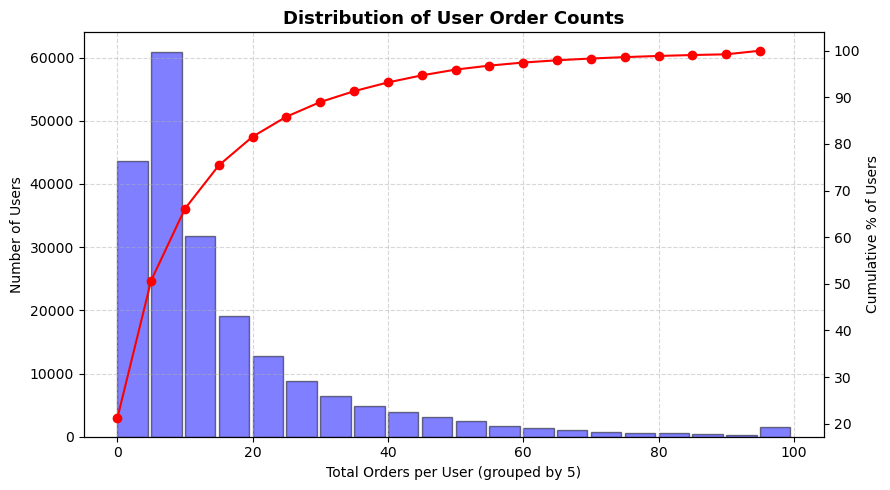

In [10]:
# Count how many orders each user placed
user_order_counts = (orders_prior.groupby("user_id")["order_number"]
                     .max().reset_index(name = "total_orders"))

# Create bins
bins = np.arange(0, 105, 5)
hist, edges = np.histogram(user_order_counts["total_orders"], bins = bins)

# Cumulative percentage of total orders per user
cumulative = np.cumsum(hist) / user_order_counts.shape[0] * 100

fig, ax1 = plt.subplots(figsize = (9,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Plotting Histogram
ax1.bar(edges[:-1], hist, width = 4.5, align="edge", 
        color="blue", edgecolor="black", alpha=0.5)
ax1.set_xlabel("Total Orders per User (grouped by 5)", fontsize=10)
ax1.set_ylabel("Number of Users", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("Distribution of User Order Counts", fontsize=13, weight="bold")

# Secondary y-axis for cumulative %
ax2 = ax1.twinx()
ax2.plot(edges[:-1], cumulative, color="red", marker="o")
ax2.set_ylabel("Cumulative % of Users", color="black")
ax2.tick_params(axis="y", labelcolor="black")

plt.tight_layout()
fig_path = FIG_DIR / "EDA-04_orders_per_user_improved.png"
plt.savefig(fig_path, dpi=150)
plt.show()


**Interpretation.**  
Most users place **fewer than 10 orders**, with over **70% of users** completing fewer than 15.The histogram’s steep left side indicates a large number of casual or first-time shoppers, while the cumulative curve shows that only a small fraction of users are highly active (30+ orders).  
This demonstrates a **long-tail user engagement pattern**; a few loyal customers account for many of the total orders. Such insights can inform retention strategies and customer segmentation.


### Product Demand
#### Top 15 Departments
This plot shows which product departments account for the highest share of orders. 
By joining prior order details with product metadata, we can identify where customer demand is concentrated across broad product categories.

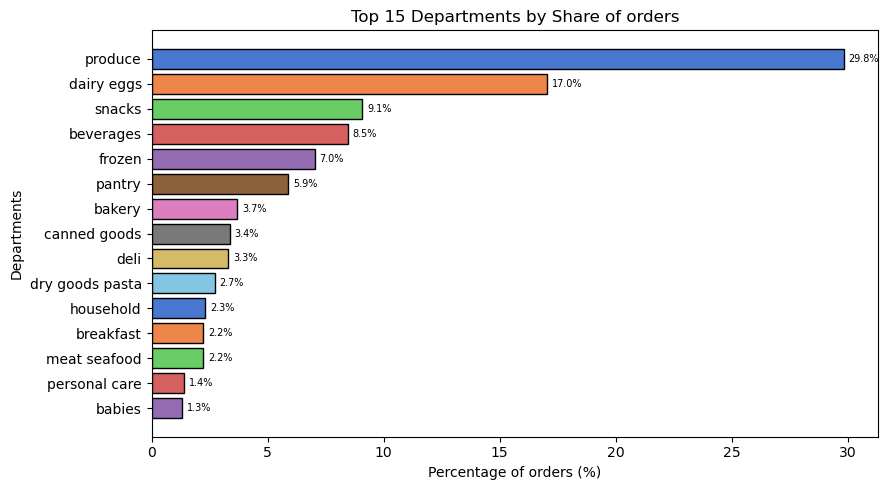

In [11]:
# Join order_products_prior with product and department info
prior_with_dept = (order_prod_prior
                   .merge(products[["product_id", "department_id"]], 
                                          on = "product_id",
                                          how = "left")
                                          .merge(departments, on = "department_id", 
                                                 how = "left"))
# Count number of orders per department for Top 15 frequently ordered products
dept_count = (prior_with_dept['department']
             .value_counts().head(15)
             .rename_axis("department").reset_index(name = 'orders'))

# Convert the number of orders per department to percentage
dept_count['percentage'] = 100 * dept_count['orders'] / dept_count['orders'].sum()

plt.figure(figsize = (9,5))
bars = plt.barh(dept_count['department'],
                dept_count['percentage'], color = sns.color_palette("muted"),
                edgecolor = 'black')

plt.title("Top 15 Departments by Share of orders")
plt.xlabel("Percentage of orders (%)")
plt.ylabel("Departments")
plt.gca().invert_yaxis()

# Annotate the bars with ordered percentage
for bar, pct in zip(bars, dept_count['percentage']):
    plt.text(pct + 0.2, bar.get_y() +
             bar.get_height()/2, 
             f"{pct:.1f}%",
             va = "center", fontsize = 7)
    
plt.tight_layout()
# Save the fig
fig_path = FIG_DIR/"EDA-05_top_department.png"
plt.savefig(fig_path, dpi = 150)
plt.show()


**Interpretation.**

The **Produce** department dominates Instacart orders, followed by **Dairy eggs**, **snakes** ,and **beverages**. This indicates that users primarily shop for fresh essential and daily use items. 
The high presence of Produce department highlights Instacart's core grocery focus, while smaller departments like babies represent niche shopping categories.

#### Top 15 Aisles by Share of orders
Aisles represent finer_grained product groupings within departments. The tree map visualizes the 15 aisles with the highest order volume, where each rectangle's area corresponds to its share of all prior order line items.

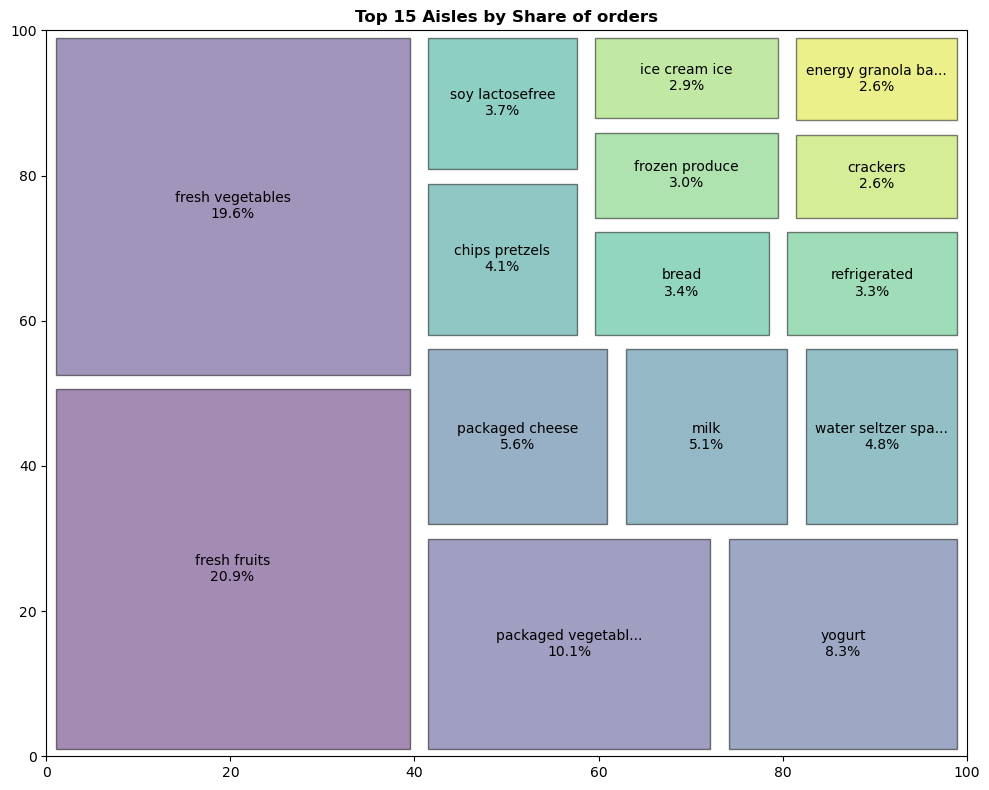

In [12]:
import squarify
import textwrap

# Join order_product_prior with product and aisle info
prior_with_aisle = (order_prod_prior.merge(products[['product_id', 'aisle_id']],
                                           on = 'product_id', how = 'left')
                                           .merge(aisles, on = 'aisle_id',
                                                  how = 'left'))
# Aggregate top 15 aisles

aisle_counts = (prior_with_aisle['aisle'].value_counts().head(15)
                .rename_axis("aisle").reset_index(name = "orders"))
aisle_counts['percentage'] = 100 * aisle_counts['orders'] / aisle_counts['orders'].sum()

def short(s, n = 18):
    return s if len(s) <= n else s[:n-1] + "..."
labels = [f"{short(a)}\n{p:.1f}%" for a, p in zip(aisle_counts['aisle'], aisle_counts['percentage'])]

# Build tree map

plt.figure(figsize = (10,8))
squarify.plot(sizes = aisle_counts['orders'],
              label = labels,
              alpha = 0.5, color = sns.color_palette('viridis', n_colors = 15), edgecolor = 'black', pad = 0.25,
              
              text_kwargs = dict(fontsize = 10) )

plt.title("Top 15 Aisles by Share of orders", fontsize = 12, weight = 'bold')
plt.tight_layout()
fig_path = FIG_DIR/"EDA-06_top_aisle.png"
plt.savefig(fig_path, dpi = 150)
plt.show()

**Interpretation.**  
The treemap shows that **Fresh Vegetables**, **Fresh Fruits**, and **Packaged Vegetables & Fruits** dominate aisle-level demand, together accounting for the largest portion of orders. Smaller tiles like **Yogurt**, **Soft Drinks**, and **Cereal** indicate strong but secondary categories.  

This emphasizes Instacart’s heavy focus on **fresh produce** and **daily essentials**, while niche aisles contribute less to total order volume. The visualization helps identify which aisles could benefit most from targeted promotions or personalized recommendations.


#### Top 15 Products by Frequency

This plot shows the 15 most frequently ordered products. It highlights the high-volume staples that define user demand at the product level.


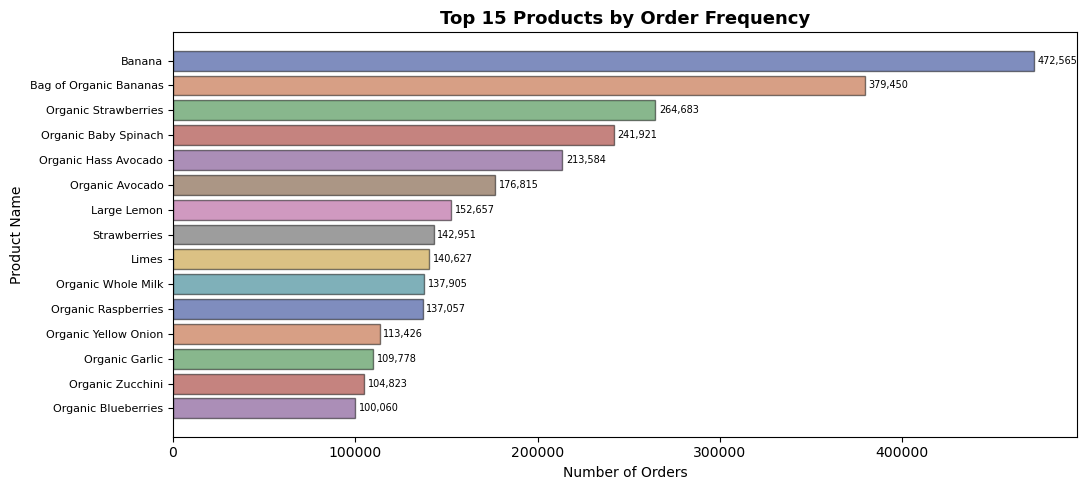

In [13]:
# Join prior orders with product names

prior_with_product = order_prod_prior.merge(
    products[["product_id", "product_name"]], on="product_id", how="left"
)

# Aggregate top 15 products
top_products = (
    prior_with_product["product_name"]
    .value_counts()
    .head(15)
    .rename_axis("product_name")
    .reset_index(name="orders")
)
top_products["percentage"] = 100 * top_products["orders"] / top_products["orders"].sum()

# Plot
plt.figure(figsize=(11, 5))
bars = plt.barh(top_products["product_name"], top_products["orders"],
                color= sns.color_palette("dark"), edgecolor="black", alpha = 0.5)
plt.gca().invert_yaxis()   # show highest on top
plt.title("Top 15 Products by Order Frequency", fontsize=13, weight="bold")
plt.xlabel("Number of Orders")
plt.ylabel("Product Name")
plt.yticks(fontsize = 8)

# Annotate bars
for bar, val in zip(bars, top_products["orders"]):
    plt.text(val + 2000, bar.get_y() + bar.get_height()/2,
             f"{val:,}", va="center", fontsize=7)

plt.tight_layout()

# Save
fig_path = FIG_DIR / "EDA-07_top_products.png"
plt.savefig(fig_path, dpi=150)
plt.show()


**Interpretation.**  
The results confirm a strong dominance of everyday staples such as **Bananas**, **Organic Strawberries**, and **Organic Baby Spinach**.  
These fresh produce items lead Instacart’s overall product frequency, underscoring that users primarily use the platform for recurring grocery basics.  

This top-products list also guides feature engineering — e.g., **product-level popularity scores** or **baseline reorder probabilities** can be derived from these counts.

### Reorder Patterns
#### Reorder Rate Day of the Week
The reorder rate is calculated as the share of line-items where `reordered = 1`.  
By examining it across the day of week, we can detect weekly rhythms in user loyalty and replenishment behavior.

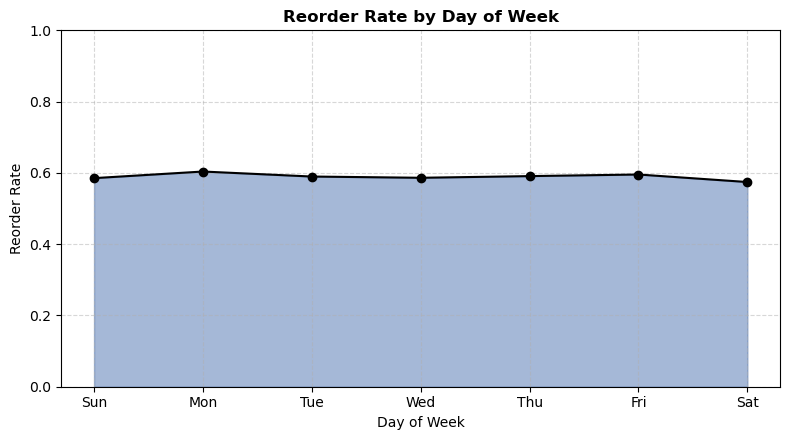

Saved figure to: reports\figures\EDA-08_reorder_rate_by_dow.png


,order_dow,reorder_rate,day
0,0,0.585276,Sun
1,1,0.603843,Mon
2,2,0.589771,Tue
3,3,0.586272,Wed
4,4,0.590979,Thu
5,5,0.595470,Fri
6,6,0.574369,Sat


In [14]:
# Merge prior order line-items with order-level info (to get day of week)
prior_with_dow = order_prod_prior.merge(
    orders_prior[["order_id", "order_dow"]], on="order_id", how="left"
)

# Compute reorder rate (mean of reordered) per day of week
reorder_dow = (
    prior_with_dow.groupby("order_dow")["reordered"]
    .mean()
    .reset_index(name="reorder_rate")
    .sort_values("order_dow")
)

# Map day numbers to names
dow_map = {0: "Sun", 1: "Mon", 2: "Tue", 3: "Wed", 4: "Thu", 5: "Fri", 6: "Sat"}
reorder_dow["day"] = reorder_dow["order_dow"].map(dow_map)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(reorder_dow["day"], reorder_dow["reorder_rate"], marker="o", color="black")
plt.fill_between(reorder_dow["day"], reorder_dow["reorder_rate"], 
                 color=sns.color_palette("deep")[0], alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.title("Reorder Rate by Day of Week", fontsize=12, weight="bold")
plt.xlabel("Day of Week")
plt.ylabel("Reorder Rate")
plt.ylim(0, 1)
plt.tight_layout()

# Save
fig_path = FIG_DIR / "EDA-08_reorder_rate_by_dow.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"Saved figure to: {fig_path}")
reorder_dow


**Interpretation.**  
Reorder rates remain fairly steady throughout the week but show a slight peak on **Sundays**. The consistency across days implies that reorder behavior is driven more by **recency and routine** than specific weekdays.


#### Reorder Rate by Hour of Day

This plot examines how the probability of reordering (`reordered = 1`) varies by hour of day. It highlights the daily cycle of repeat-purchase behavior.


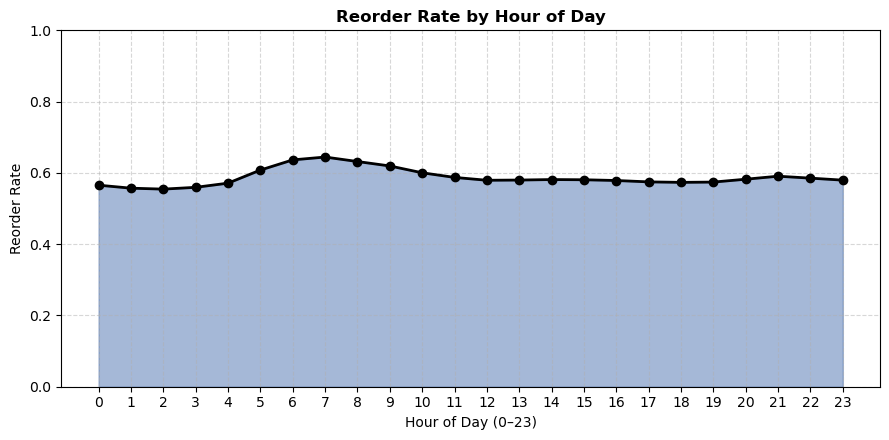

Saved figure to: reports\figures\EDA-09_reorder_rate_by_hour.png


,order_hour_of_day,reorder_rate
0,0,0.565500
1,1,0.557114
2,2,0.554455
3,3,0.559498
4,4,0.571195


In [15]:
# Merge once to bring in order_hour_of_day
prior_with_hour = order_prod_prior.merge(
    orders_prior[["order_id", "order_hour_of_day"]], on="order_id", how="left"
)

# Reorder rate by hour of day
reorder_hour = (
    prior_with_hour.groupby("order_hour_of_day")["reordered"]
    .mean()
    .reset_index(name="reorder_rate")
    .sort_values("order_hour_of_day")
)

# Plot
plt.figure(figsize=(9, 4.5))
plt.plot(reorder_hour["order_hour_of_day"], reorder_hour["reorder_rate"],
         marker="o", color="black", linewidth=2)
plt.fill_between(reorder_hour["order_hour_of_day"], reorder_hour["reorder_rate"],
                 color=sns.color_palette("deep")[0], alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.title("Reorder Rate by Hour of Day", fontsize=12, weight="bold")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Reorder Rate")
plt.xticks(range(0, 24))
plt.ylim(0, 1)
plt.tight_layout()

fig_path = FIG_DIR / "EDA-09_reorder_rate_by_hour.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"Saved figure to: {fig_path}")
reorder_hour.head()


**Interpretation.**  
Reorder rates increase during the **early morning**, peaking around **7 AM**,  then gradually decline into late evening.  

This mirrors the overall ordering pattern seen earlier but now confirms that **habitual reorders** follow the same daily rhythm users tend to restock regular items during typical morning shopping windows.


#### Reorder Rate vs. Days Since Prior Order

This visualization explores how recency (measured by `days_since_prior_order`) influences the reorder rate. It helps confirm the intuition that shorter gaps between orders often lead to higher reorder probabilities.


C:\Users\prajw\AppData\Local\Temp\ipykernel_16604\1066680760.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["days_bin"] = pd.cut(valid["days_since_prior_order"],
C:\Users\prajw\AppData\Local\Temp\ipykernel_16604\1066680760.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reorder_recency = (valid.groupby("days_bin")["reordered"]


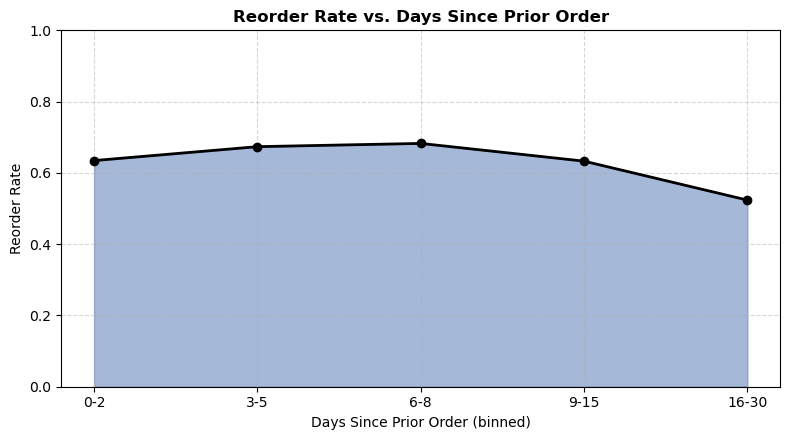

Saved figure to: reports\figures\EDA-10_reorder_rate_vs_days.png


,days_bin,reorder_rate
0,0-2,0.634559
1,3-5,0.673562
2,6-8,0.682704
3,9-15,0.632948
4,16-30,0.523690
5,31-60,NaN


In [16]:
# Create a Series mapping order_id -> days_since_prior_order
days_map = orders_prior.set_index("order_id")["days_since_prior_order"]

# Add it directly as a new column using .map() (much lighter than merge)
order_prod_prior["days_since_prior_order"] = order_prod_prior["order_id"].map(days_map)

valid = order_prod_prior.dropna(subset=["days_since_prior_order"])

bins = [0, 2, 5, 8, 15, 30, 60]
labels = ["0-2", "3-5", "6-8", "9-15", "16-30", "31-60"]
valid["days_bin"] = pd.cut(valid["days_since_prior_order"], 
                           bins=bins, labels=labels, right=True)

reorder_recency = (valid.groupby("days_bin")["reordered"]
                   .mean().reset_index(name="reorder_rate"))

plt.figure(figsize=(8, 4.5))
plt.plot(reorder_recency["days_bin"], reorder_recency["reorder_rate"],
         marker="o", color="black", linewidth=2)
plt.fill_between(reorder_recency["days_bin"].astype(str),
                 reorder_recency["reorder_rate"], 
                 color=sns.color_palette("deep")[0], alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.title("Reorder Rate vs. Days Since Prior Order", fontsize=12, weight="bold")
plt.xlabel("Days Since Prior Order (binned)")
plt.ylabel("Reorder Rate")
plt.ylim(0, 1)
plt.tight_layout()

fig_path = FIG_DIR / "EDA-10_reorder_rate_vs_days.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"Saved figure to: {fig_path}")
reorder_recency


**Interpretation.**  
Reorder rates are highest when the gap between purchases is short - typically within **0-8 days** and decline steadily as the interval increases.  
This confirms that **recency is a strong driver of reorder behavior**, aligning with expectations from customer-loyalty theory: recent shoppers are more likely to repurchase habitual products, while longer gaps reduce reorder likelihood.


#### Reorder Rate Across Order Sequence

This plot examines how the likelihood of reordering changes as a user's order count increases (`order_number`). Early orders typically include new items, while later orders contain more habitual reorders.


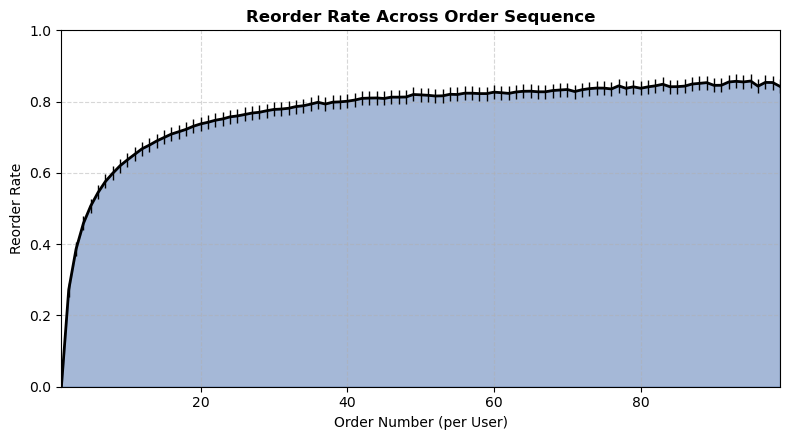

Saved figure to: reports\figures\EDA-11_reorder_rate_across_sequence.png


,order_number,reorder_rate
0,1,0.000000
1,2,0.272361
2,3,0.386282
3,4,0.458345
4,5,0.507394


In [17]:
# Map order_number onto order_prod_prior
order_number_map = orders_prior.set_index("order_id")["order_number"]
order_prod_prior["order_number"] = order_prod_prior["order_id"].map(order_number_map)

# Compute reorder rate by order_number
reorder_sequence = (
    order_prod_prior.groupby("order_number")["reordered"]
    .mean()
    .reset_index(name="reorder_rate")
)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(reorder_sequence["order_number"], reorder_sequence["reorder_rate"],
         marker="|", color="black", linewidth=2, markersize=10)
plt.fill_between(reorder_sequence["order_number"], reorder_sequence["reorder_rate"],
                 color=sns.color_palette("deep")[0], alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.title("Reorder Rate Across Order Sequence", fontsize=12, weight="bold")
plt.xlabel("Order Number (per User)")
plt.ylabel("Reorder Rate")
plt.ylim(0, 1)
plt.xlim(1, reorder_sequence["order_number"].max())
plt.tight_layout()

# Save
fig_path = FIG_DIR / "EDA-11_reorder_rate_across_sequence.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"Saved figure to: {fig_path}")
reorder_sequence.head()


**Interpretation.**  
Reorder rates start relatively low in the first few orders and rise steadily up to around the 10th - 20th order, after which they plateau.  
This pattern reflects a **user lifecycle**: new customers experiment with products at first, then increasingly reorder familiar favorites as they develop trust and routine.  
Such insights can help distinguish between **new vs. loyal users** in predictive modeling or retention strategies.


#### Product Popularity vs. Reorder Rate

This scatter plot compares each product's total purchase count (popularity) to its reorder rate. Highly popular items with high reorder rates indicate core staples that customers repeatedly buy.


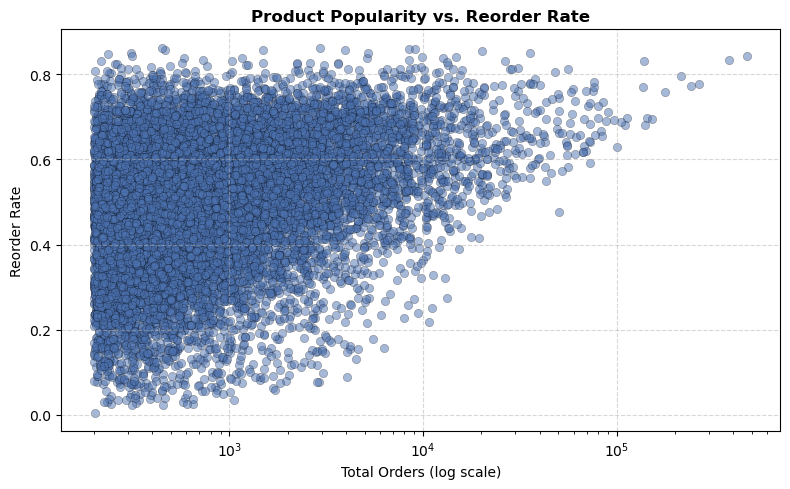

Saved figure to: reports\figures\EDA-12_popularity_vs_reorder.png


,product_id,total_orders,reorder_rate,product_name
0,1,1852,0.613391,Chocolate Sandwich Cookies
2,3,277,0.732852,Robust Golden Unsweetened Oolong Tea
3,4,329,0.446809,Smart Ones Classic Favorites Mini Rigatoni Wit...
9,10,2572,0.506998,Sparkling Orange Juice & Prickly Pear Beverage
11,12,246,0.512195,Chocolate Fudge Layer Cake


In [18]:
# Compute popularity (total count) and reorder rate per product
product_stats = (
    order_prod_prior.groupby("product_id")["reordered"]
    .agg(["count", "mean"])
    .rename(columns={"count": "total_orders", "mean": "reorder_rate"})
    .reset_index()
)

# Add product names for interpretability
product_stats = product_stats.merge(products[["product_id", "product_name"]], on="product_id", how="left")

# Filter to products with sufficient data (avoid noisy small counts)
filtered = product_stats.query("total_orders >= 200")

# Plot scatter
plt.figure(figsize=(8, 5))
plt.scatter(filtered["total_orders"], filtered["reorder_rate"],
            alpha=0.5, color=sns.color_palette("deep")[0],
              edgecolor="black", linewidth=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xscale("log")  # popularity spans huge range, log scale shows it clearly
plt.title("Product Popularity vs. Reorder Rate", fontsize=12, weight="bold")
plt.xlabel("Total Orders (log scale)")
plt.ylabel("Reorder Rate")
plt.tight_layout()

# Save
fig_path = FIG_DIR / "EDA-12_popularity_vs_reorder.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"Saved figure to: {fig_path}")
filtered.head()


**Interpretation.**  
The scatter shows that while many products cluster around reorder rates of **0.4–0.7**, some moderately popular items achieve **very high loyalty** despite fewer total orders. For example, niche products like *Fancy Feast Trout Feast Flaked Wet Cat Food* and *Robust Golden Unsweetened Oolong Tea* show reorder rates above **0.73**, indicating that **customer loyalty is not solely tied to popularity**.  
Highly ordered items maintain steady reordering, but dedicated niches reveal  
strong repeat behavior within smaller shopper segments.


### Results Summary

The exploratory data analysis (EDA) of the Instacart Online Grocery Shopping dataset revealed key insights into user behavior, product demand, and reorder patterns, providing a strong foundation for subsequent modeling and feature engineering.

### 1. User Behavior
User activity follows clear temporal patterns:
- **Weekly cycle:** Order volume peaks on **Sundays and Mondays**, indicating customers tend to restock groceries early in the week.
- **Daily rhythm:** Most orders are placed between **10 AM and 4 PM**, suggesting users prefer midday shopping, possibly during breaks or after work hours.
- **Purchase frequency:** The average gap between orders is about **7–8 days**, with secondary peaks at **30 days**, reflecting weekly and monthly shopping routines.
- **Engagement distribution:** Over **70% of users place fewer than 15 total orders**, while a small group of highly active users (30+ orders) accounts for a large share of transactions—highlighting a **long-tail distribution** in customer engagement.

### 2. Product Demand
Product-level analysis showed that Instacart’s business is dominated by essential grocery items:
- The **Produce department** is the top contributor to total orders, followed by **Dairy & Eggs**, **Snacks**, and **Beverages**, demonstrating a focus on fresh and daily-use goods.
- At the aisle level, **Fresh Vegetables**, **Fresh Fruits**, and **Packaged Produce** dominate, confirming users’ emphasis on perishable grocery staples.
- The most frequently purchased individual products are **Bananas**, **Organic Strawberries**, and **Organic Baby Spinach**, reinforcing that Instacart usage centers on recurring household essentials.

### 3. Reorder Patterns
Patterns of customer loyalty and repetition emerged strongly:
- **Day-of-week effect:** Reorder rates remain relatively consistent but peak slightly on **Sundays**, mirroring general order volume.
- **Time-of-day effect:** Reorders are most common during **morning hours**, aligning with typical shopping times.
- **Recency influence:** Reorder rates are highest when the previous purchase occurred within **0–8 days** and decline steadily as the interval grows, confirming **recency as a major driver of reorder behavior**.
- **User lifecycle:** Reorder probability increases sharply over the first 10–15 orders and then plateaus, showing how shoppers transition from exploratory to habitual purchasing.
- **Product loyalty:** While most products exhibit reorder rates between **0.4–0.7**, certain moderately popular items (e.g., *Fancy Feast Trout Feast Flaked Wet Cat Food*, *Robust Golden Unsweetened Oolong Tea*) achieve **loyalty above 0.73**, proving that **repeat purchases are not solely tied to popularity** but to user preference niches.

These results collectively demonstrate clear behavioral rhythms and loyalty patterns that can guide the creation of predictive features such as time-based variables, recency indicators, product popularity scores, and reorder probability baselines for building effective recommendation and ranking models in the next phase.
